In [1]:
#import basic libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspe
import seaborn as sns
import polars as pl

import os
from multiprocessing import Pool, cpu_count
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.optimize import minimize

# I. Data Exploratory Analysis (EDA) & Data Prepossessing 

## 1. Data Loading

In [2]:
dic = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

##  2. Data Preview

### 2.1. Preview Data_dictionary
The HBN dataset has total 11 instruments. Each one are presented by some fields calculated below. The total number of fields collected is 80 (excluding id).

In [3]:
# Preview data_dictionary
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
dic.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [4]:
# Summarise data_dictionary
# grouped = dic.groupby('Instrument', sort=False)['Field'].apply(lambda x: ', '.join(x)).reset_index()
# grouped['NumFields'] = dic.groupby('Instrument', sort=False).size().values
# grouped = grouped.style.set_properties(**{'text-align': 'left'}, subset=['Instrument', 'Field', 'NumFields']) \
    # .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

# grouped

### 2.2. Preview Train & Test data

In [5]:
# training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

2736 non-null in sii => 
sii missing is about 30% (accepted to remove), so only use part with sii valid to train the supervised model for accurately.

In [6]:
usable_train_df = train_df.dropna(subset='sii')
usable_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      2736 non-null   object 
 1   Basic_Demos-Enroll_Season               2736 non-null   object 
 2   Basic_Demos-Age                         2736 non-null   int64  
 3   Basic_Demos-Sex                         2736 non-null   int64  
 4   CGAS-Season                             2342 non-null   object 
 5   CGAS-CGAS_Score                         2342 non-null   float64
 6   Physical-Season                         2595 non-null   object 
 7   Physical-BMI                            2527 non-null   float64
 8   Physical-Height                         2530 non-null   float64
 9   Physical-Weight                         2572 non-null   float64
 10  Physical-Waist_Circumference            483 non-null    float64
 

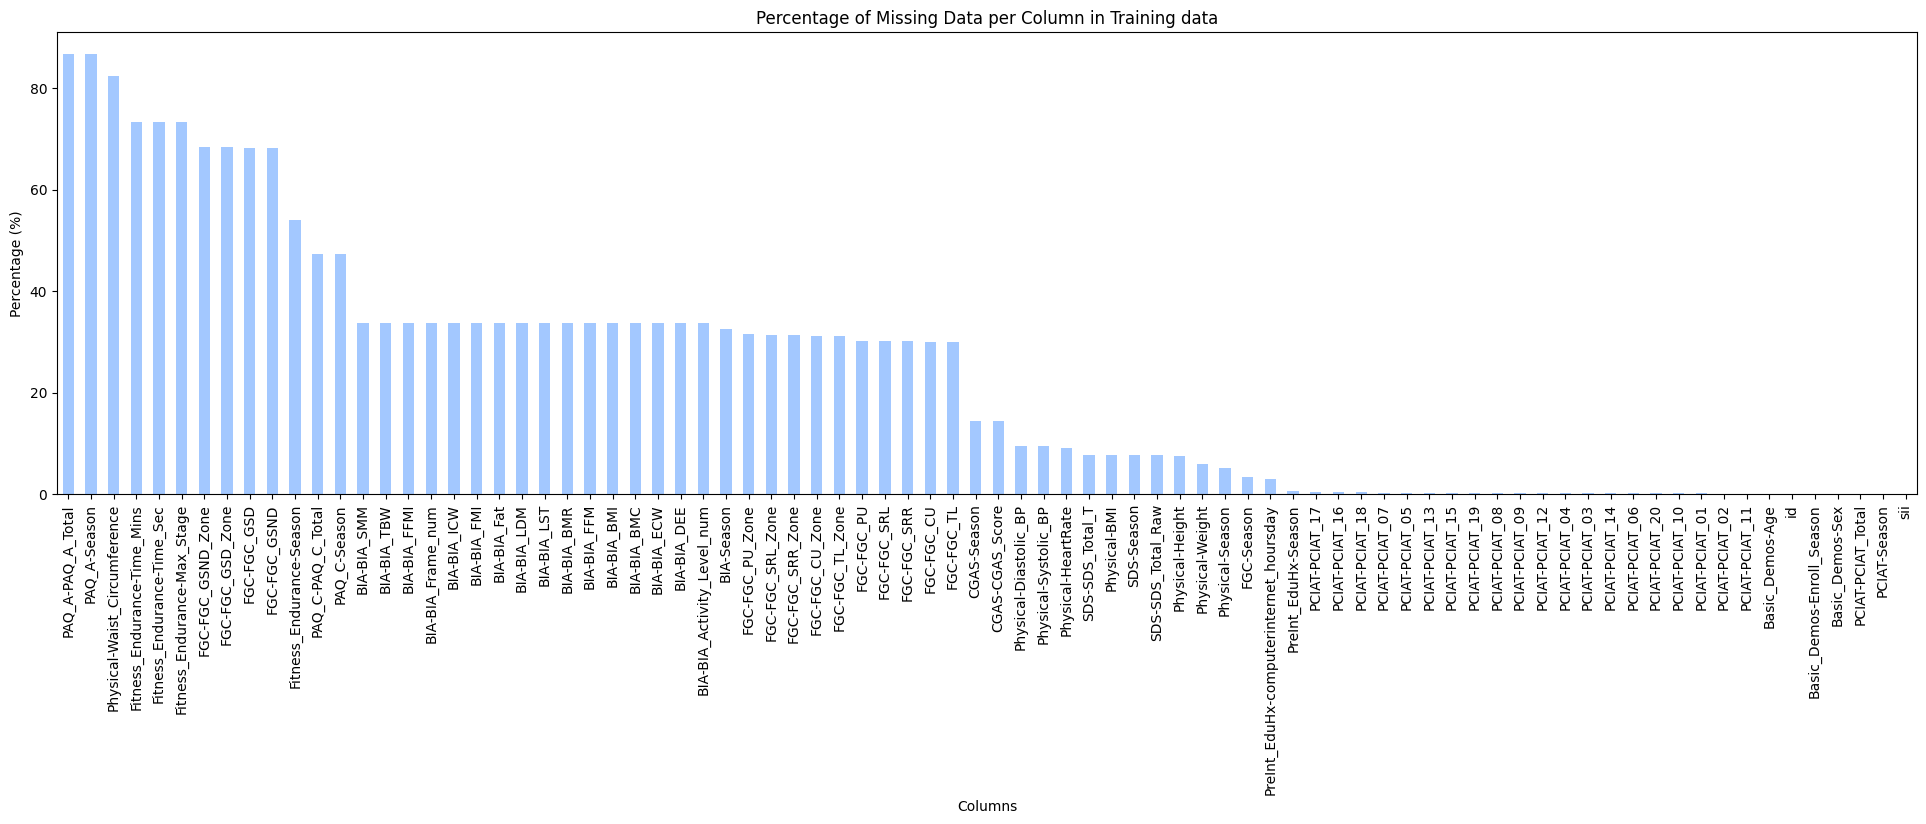

In [7]:
missing_percentage = (usable_train_df.isnull().sum() / len(usable_train_df)) * 100 # calculate % missing data

missing_percentage.sort_values(ascending=False).plot(kind='bar', color='#A3C8FF', figsize=(24, 6))
plt.title('Percentage of Missing Data per Column in Training data')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns');

In [8]:
#Testing data
test_df.info()
# 58 fields measured (excluding id) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [9]:
# missing_percentage_test = (test_df.isnull().sum() / len(test_df)) * 100 # calculate % missing data

# missing_percentage_test.sort_values(ascending=False).plot(kind='bar', color='orange', figsize=(24, 6))
# plt.title('Percentage of Missing Data per Column in Testing data')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Testing data');

In [10]:
# find the difference between 2 files
print([f for f in train_df.columns if f not in test_df.columns])
# columns_train = set(usable_train_df.columns)
# columns_test = set(test_df.columns)
# difference = sorted(list(columns_train - columns_test)) #Find the difference columns in 2 data files
# print(difference) # 23

['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


### 2.3. Features Classification

In [11]:
# Identify the type of fields (features to train)
def print_column_info(column_type, column_name):
    cols = dic[dic['Type'] == column_type]['Field']
    print(f"{column_name}: {len(cols)}")
    print(cols.values)
    print("\n")

print_column_info('float', 'Continuous')
print_column_info('int', 'Discrete')
print_column_info('str', 'Categorical')
print_column_info('categorical int', 'Categorical Int')


Continuous: 24
['Basic_Demos-Age' 'Physical-BMI' 'Physical-Height' 'Physical-Weight'
 'FGC-FGC_GSND' 'FGC-FGC_GSD' 'FGC-FGC_SRL' 'FGC-FGC_SRR' 'BIA-BIA_BMC'
 'BIA-BIA_BMI' 'BIA-BIA_BMR' 'BIA-BIA_DEE' 'BIA-BIA_ECW' 'BIA-BIA_FFM'
 'BIA-BIA_FFMI' 'BIA-BIA_FMI' 'BIA-BIA_Fat' 'BIA-BIA_ICW' 'BIA-BIA_LDM'
 'BIA-BIA_LST' 'BIA-BIA_SMM' 'BIA-BIA_TBW' 'PAQ_A-PAQ_A_Total'
 'PAQ_C-PAQ_C_Total']


Discrete: 14
['CGAS-CGAS_Score' 'Physical-Waist_Circumference' 'Physical-Diastolic_BP'
 'Physical-HeartRate' 'Physical-Systolic_BP' 'Fitness_Endurance-Max_Stage'
 'Fitness_Endurance-Time_Mins' 'Fitness_Endurance-Time_Sec' 'FGC-FGC_CU'
 'FGC-FGC_PU' 'FGC-FGC_TL' 'PCIAT-PCIAT_Total' 'SDS-SDS_Total_Raw'
 'SDS-SDS_Total_T']


Categorical: 12
['id' 'Basic_Demos-Enroll_Season' 'CGAS-Season' 'Physical-Season'
 'Fitness_Endurance-Season' 'FGC-Season' 'BIA-Season' 'PAQ_A-Season'
 'PAQ_C-Season' 'PCIAT-Season' 'SDS-Season' 'PreInt_EduHx-Season']


Categorical Int: 31
['Basic_Demos-Sex' 'FGC-FGC_CU_Zone' 'FGC-FGC_GSN

### 2.4. Distribution of features

In [12]:
# Distribution of numerical features
# usable_train_df.describe()

In [13]:
#categorical features
usable_train_df.select_dtypes(include=["object"]).describe()

,id,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
count,2736,2736,2342,2595,1260,2647,1844,363,1440,2736,2527,2719
unique,2736,4,4,4,4,4,4,4,4,4,4,4
top,ffed1dd5,Spring,Spring,Spring,Spring,Spring,Summer,Winter,Spring,Spring,Spring,Spring
freq,1,734,665,709,377,771,585,98,405,762,692,728


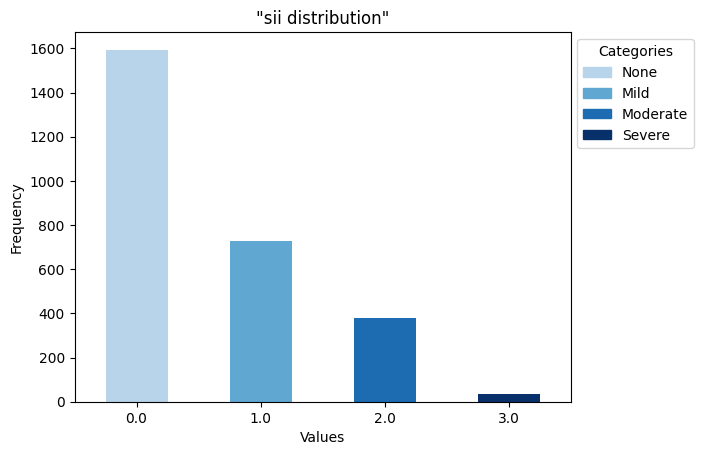

In [14]:
# sii distribution → sii is imbalanced, half of it is 0
sii_counts = usable_train_df['sii'].value_counts()
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sii_counts)))

#plt.figure(figsize=(12, 6))
sii_counts.plot(kind='bar', color=colors)
plt.title('"sii distribution"')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
legend_labels = ['None', 'Mild', 'Moderate', 'Severe']
colors_for_legend = colors
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_for_legend],
           labels=legend_labels, title="Categories", loc='upper left', bbox_to_anchor=(1, 1));


## EDA


### 2.1. Encode Season columns

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
columns_to_encode = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

for col in columns_to_encode:
    # Áp dụng LabelEncoder và giữ lại giá trị NaN
    train_df[col] = encoder.fit_transform(train_df[col].astype(str)).astype(int)

test_col_to_encode = [col for col in columns_to_encode if col != 'PCIAT-Season']

for col in test_col_to_encode:
    test_df[col] = encoder.transform(test_df[col].astype(str)).astype(int)

usable_train_df = train_df.dropna(subset=['sii'])


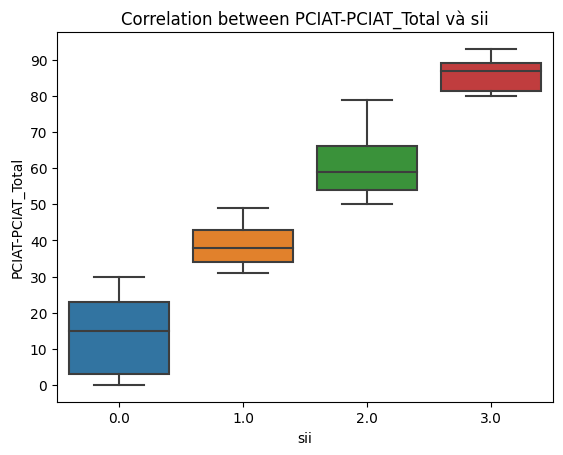

In [16]:
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=usable_train_df)
plt.title('Correlation between PCIAT-PCIAT_Total và sii')
plt.xlabel('sii')
plt.ylabel('PCIAT-PCIAT_Total')
y_ticks = np.arange(usable_train_df['PCIAT-PCIAT_Total'].min(), usable_train_df['PCIAT-PCIAT_Total'].max(), 10)
plt.yticks(y_ticks);

The target ```sii``` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score.
* 0-30 Normal (0)
* 31-49 Mild (1)
* 50-79 Moderate (2)
* 80-100 Severe (3)

Proof: https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_SRL                              -0.091221
FGC-FGC_SRR                              -0.077836
BIA-BIA_BMI                               0.248060
BIA-BIA_DEE                               0.053094
BIA-BIA_FFMI                              0.109694
BIA-BIA_FMI                               0.085863
BIA-BIA_ICW                               0.052593
BIA-BIA_LST                               0.075623
BIA-BIA_SMM                               0.052912
CGAS-CGAS_Score                          -0.070542
Physical-Waist_Circumference              0.327013
Physical-Diastolic_BP                     0.069321
Physical-Systolic_BP                      0.147081
Fitness_Endurance-Time_Mins    

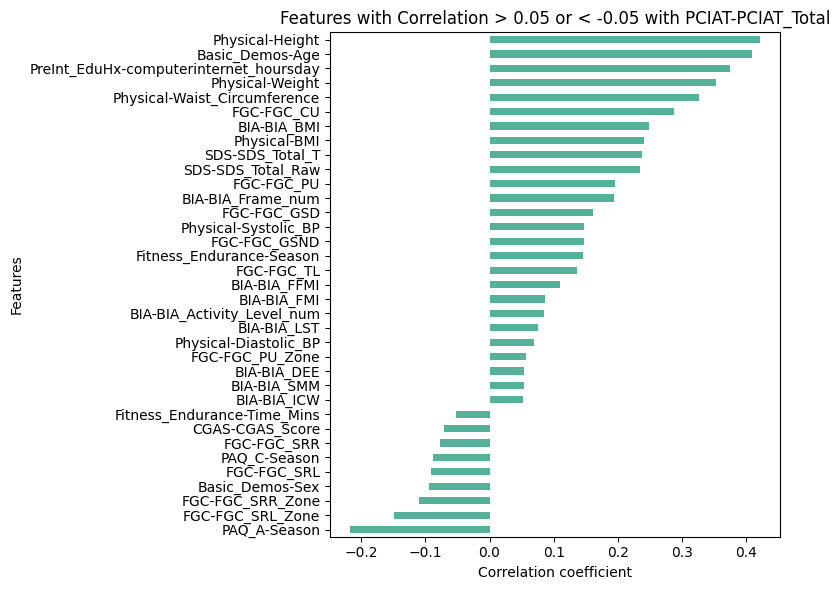

In [17]:
# Check correlation between numerical features and PCIAT Total Scores

corr_matrix = usable_train_df[[
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
 'FGC-FGC_GSND' ,'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE' ,'BIA-BIA_ECW', 'BIA-BIA_FFM',
 'BIA-BIA_FFMI' ,'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW' ,'BIA-BIA_LDM',
 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
 'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score' ,'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
 'Physical-HeartRate', 'Physical-Systolic_BP' ,'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec' ,'FGC-FGC_CU',
 'FGC-FGC_PU', 'FGC-FGC_TL' ,'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone' ,'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone' ,'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num', 
    
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]].corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.05) | (sii_corr < -0.05)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='#55B197')
plt.title('Features with Correlation > 0.05 or < -0.05 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# II. Feature Engineering

### 2.2. Handle Actigraphy data

In [18]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

# Function to process a single file
def process_file(filename, dirname):
    filepath = Path(dirname) / filename / 'part-0.parquet'
    df = pd.read_parquet(filepath)
    df = df.drop(columns='step') 
    return df.describe().values.reshape(-1), filename.split('=')[1]

# Function to load and process all files in parallel
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    num_threads = min(len(ids), 
                      os.cpu_count() * 4) # add more CPU
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3), nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2), nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2), nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3), nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to train and use the AutoEncoder
def autoencode_data(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            loss = criterion(autoencoder(batch), batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    return pd.DataFrame(encoded_data, columns=[f'Acti_{i + 1}' for i in range(encoded_data.shape[1])])

In [19]:
#read
train_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

#encode
train_ts = autoencode_data(train_acti.drop('id', axis=1))
test_ts = autoencode_data(test_acti.drop('id', axis=1))

train_ts['id'] = train_acti['id']
test_ts['id'] = test_acti['id']

100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


Epoch [10/50], Loss: 1.6351
Epoch [20/50], Loss: 1.5681
Epoch [30/50], Loss: 1.5388
Epoch [40/50], Loss: 1.5098
Epoch [50/50], Loss: 1.5085
Epoch [10/50], Loss: 1.0221
Epoch [20/50], Loss: 0.7694
Epoch [30/50], Loss: 0.4418
Epoch [40/50], Loss: 0.4271
Epoch [50/50], Loss: 0.4271


### 2.1 Feature selection

In [20]:
# choose features with high correlation
featuresCols = ["Basic_Demos-Age", "Physical-BMI", "Physical-Height", "Physical-Weight", 
    "FGC-FGC_GSND", "FGC-FGC_GSD", "FGC-FGC_SRL", "FGC-FGC_SRR", 
    "BIA-BIA_BMI", "BIA-BIA_DEE", "BIA-BIA_FFMI", "BIA-BIA_FMI", 
    "BIA-BIA_ICW", "BIA-BIA_LST", "BIA-BIA_SMM", "CGAS-CGAS_Score", 
    "Physical-Waist_Circumference", "Physical-Diastolic_BP", "Physical-Systolic_BP", 
    "Fitness_Endurance-Time_Mins", "FGC-FGC_CU", "FGC-FGC_PU", "FGC-FGC_TL", 
    "SDS-SDS_Total_Raw", "SDS-SDS_Total_T", "PreInt_EduHx-computerinternet_hoursday", 
    "Basic_Demos-Sex", "FGC-FGC_PU_Zone", "FGC-FGC_SRL_Zone", "FGC-FGC_SRR_Zone", 
    "BIA-BIA_Activity_Level_num", "BIA-BIA_Frame_num", "Fitness_Endurance-Season", 
    "PAQ_A-Season", "PAQ_C-Season" ]
#filter features has >50% missing data
columns_with_missing = missing_percentage[missing_percentage > 50].index
missCols = usable_train_df[columns_with_missing]
# print(missCols)

selectedFeatures = list(set(featuresCols) - set(missCols))
selected_df = usable_train_df[["id"] + [col for col in selectedFeatures if col != "id"]]

test = test_df[["id"]+ selectedFeatures]
test.head()

,id,Basic_Demos-Age,Physical-Systolic_BP,BIA-BIA_FFMI,BIA-BIA_BMI,FGC-FGC_SRR,Physical-Weight,Physical-Diastolic_BP,BIA-BIA_ICW,BIA-BIA_LST,SDS-SDS_Total_Raw,Physical-BMI,SDS-SDS_Total_T,FGC-FGC_SRR_Zone,FGC-FGC_PU_Zone,FGC-FGC_TL,CGAS-CGAS_Score,Basic_Demos-Sex,FGC-FGC_SRL,FGC-FGC_SRL_Zone,PAQ_C-Season,BIA-BIA_Activity_Level_num,Physical-Height,BIA-BIA_Frame_num,PreInt_EduHx-computerinternet_hoursday,BIA-BIA_SMM,BIA-BIA_DEE,BIA-BIA_FMI,FGC-FGC_PU,FGC-FGC_CU
0,00008ff9,5,NaN,13.8177,16.8792,6.0,50.8,NaN,24.4349,38.9177,NaN,16.877316,NaN,0.0,0.0,6.0,51.0,0,7.0,0.0,4,2.0,46.0,1.0,3.0,19.5413,1492.00,3.06143,0.0,0.0
1,000fd460,9,122.0,12.8254,14.0371,11.0,46.0,75.0,21.0352,39.4497,46.0,14.035590,64.0,1.0,0.0,3.0,NaN,0,11.0,1.0,0,2.0,48.0,1.0,0.0,15.4107,1498.65,1.21172,5.0,3.0
2,00105258,10,117.0,NaN,NaN,10.0,75.6,65.0,NaN,NaN,38.0,16.648696,54.0,1.0,1.0,5.0,71.0,1,10.0,1.0,2,NaN,56.5,NaN,2.0,NaN,NaN,NaN,7.0,20.0
3,00115b9f,9,117.0,14.0740,18.2943,7.0,81.6,60.0,30.4041,58.9338,31.0,18.292347,45.0,0.0,0.0,7.0,71.0,0,7.0,0.0,3,3.0,56.0,2.0,0.0,26.4798,1923.44,4.22033,5.0,18.0
4,0016bb22,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
selected_df = selected_df.merge(train_ts, on='id', how='left')
test = test.merge(test_ts, on='id', how='left')

In [22]:
selected_df = selected_df.drop(columns='id')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 80 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Age                         20 non-null     int64  
 2   Physical-Systolic_BP                    11 non-null     float64
 3   BIA-BIA_FFMI                            8 non-null      float64
 4   BIA-BIA_BMI                             8 non-null      float64
 5   FGC-FGC_SRR                             13 non-null     float64
 6   Physical-Weight                         13 non-null     float64
 7   Physical-Diastolic_BP                   11 non-null     float64
 8   BIA-BIA_ICW                             8 non-null      float64
 9   BIA-BIA_LST                             8 non-null      float64
 10  SDS-SDS_Total_Raw                       10 non-null     float64


### 2.2. Handle missing data

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=20, random_state=0)

selected_df = pd.DataFrame(imputer.fit_transform(selected_df), columns=selected_df.columns)
#selected_df.head()

# III. Model training

### Model

In [24]:
Params_LGB = {
   'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,
    'verbose': -1
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 0,
    'tree_method': 'hist',  
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 0,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'CPU' 
}


In [25]:
lgb_model = lgb.LGBMRegressor(**Params_LGB)
xgb_model = xgb.XGBRegressor(**XGB_Params)
catboost_model = cb.CatBoostRegressor(**CatBoost_Params)

# Voting Regression

voting_clf = VotingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model),
    ]
) 

In [26]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [27]:
def ModelTraining(X,y, test_data):
    SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
   
    # store QWK
    train_S = []
    test_S = []
    
    # create array storing prediction to calculate QWK
    oof_non_rounded = np.zeros(len(y), dtype=float)  # used for training set
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), 10))  # used for testing set

    # training loop
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=10)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        
        voting_clf.fit(X_train, y_train)

        # predict on traing & testing set
        y_train_pred = voting_clf.predict(X_train)
        y_val_pred = voting_clf.predict(X_val)
        
        # update prediction
        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        # Calculate QWK for training and validation
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)
        
        # Store QWK scores for each fold
        train_S.append(train_kappa)
        test_S.append(val_kappa)

        # Store the predictions for the test set
        test_preds[:, fold] = voting_clf.predict(test_data)

    # After all folds
    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK --> {np.mean(test_S):.4f}")

    # Optimize threshold
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    
    
    # Tune the OOF predictions using optimized thresholds
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {tKappa:.3f}")

    # Average test predictions across all folds
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    # Create the submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'sii': tpTuned
    })

    return submission

    # Create submission
    submission = pd.DataFrame({
        'id': test['id'],  # Assuming test_data has an index for IDs
        'sii': tpTuned
    })

    print("Submission created successfully!")
    return submission


In [28]:
# define input
X = selected_df
y = usable_train_df['sii']
test_data_use = test.drop(columns="id")

# Submit

In [29]:
submission = ModelTraining(X, y, test_data_use)

Training Folds: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Mean Train QWK --> 0.7423
Mean Validation QWK --> 0.3972
----> || Optimized QWK SCORE :: 0.465


In [30]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [31]:
submission['sii'].value_counts()

sii
1    10
0    10
Name: count, dtype: int64

In [32]:
submission.to_csv("submission.csv", index=False)